# Grid Search - EEGExtractor
Notebook przedstawia proces wyboru optymalnych parametrów extractora za pomocą gridsearcha (sprawdzanie każdej możliwej kombinacji parametrów)
Ze względu na kosztownośc techniki, podzieliłem go na 3 mniejsze trwające krócej, gdzie każdy kolejny wyciąga wnioski z wcześniejszego co pozwala ograniczyć testowanie zbędnych kombinacji i skupienie się na tych które pozytywnie trendują

# Model:
Podczas testów został użyty model **typu konwolucyjnego** zawierający 3 warstwy konwolucyjne, następnie globalny avgpooling

# Funkcja straty:
Testy bazują na TripletLoss z Online Mining tzn. że trójki wybierane są na bieżąco jako skrajne wartości (tzw. hardest_positive, hardest_negative)

# Grid Search v1

Pierwszy **grid search**, który rozważył **91 przypadków**, daje pierwsze poglądowe wyniki, które widoczne są w poniższym notebooku.

Skupiłem się w nim na analizie parametrów **`EEGExtractora`** takich jak:

- **`lfreq`** – *Dolna granica pasma częstotliwości przepuszczanego przez filtr pasmowoprzepustowy*:  
  `lfreq = [0.5, 1.0, 4.0]`

- **`hfreq`** – *Górna granica pasma częstotliwości przepuszczanego przez filtr pasmowoprzepustowy*:  
  `hfreq = [30.0, 50.0, 100.0]`

- **`tmin`** – *Początek przedziału czasowego (w sekundach) względem zdarzenia (eventu), z którego ekstraktowane są dane*:  
  `tmin = [-0.5, 0.0]`

- **`tmax`** – *Koniec przedziału czasowego (w sekundach) względem zdarzenia (eventu), z którego ekstraktowane są dane*:  
  `tmax = [1.0, 2.0, 3.0, 4.0]`

- **`notch_filter`** – *Częstotliwość (lub lista częstotliwości), na której stosowany jest filtr wycinający (notch filter)*:  
  `notch_filter = [[50.0], [50.0, 100.0]]`


In [1]:
import pandas as pd
from eeg_lib.utills.visualisations import plot_tsne
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mean_line(df, x_col, y_col, title=None):
    """
    Rysuje wykres liniowy średnich wartości y_col względem x_col.

    Args:
        df (pd.DataFrame): DataFrame z danymi
        x_col (str): nazwa kolumny dla osi X
        y_col (str): nazwa kolumny dla osi Y
        title (str, optional): tytuł wykresu
    """

    grouped = df.groupby(x_col)[y_col].mean().reset_index()
    grouped = grouped.sort_values(by=x_col)

    plt.figure(figsize=(8, 5))
    plt.plot(grouped[x_col], grouped[y_col], marker='o')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title if title else f'{y_col} względem {x_col}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_triplet_loss(df, x_column, y_column='final_loss'):
    """
    Tworzy estetyczny wykres zależności triplet loss od wybranej kolumny.

    Parametry:
    - df: pandas.DataFrame z danymi
    - x_column: str, kolumna na osi X (np. 'lfreq')
    - y_column: str, kolumna triplet loss (domyślnie 'final_loss')
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 12})

    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(
        x=x_column, 
        y=y_column, 
        data=df, 
        color='royalblue', 
        alpha=0.9, 
        edgecolor='k'
    )

    plt.xlabel(x_column, fontsize=14)
    plt.ylabel('Triplet Loss', fontsize=14)
    plt.title(f'Zależność między {x_column} a Triplet Loss', fontsize=16, weight='bold')

    plt.grid(True, linestyle='--', alpha=0.9)
    plt.tight_layout()
    plt.show()


In [2]:
df = pd.read_json('grid_search_final_form.json')

df_params = df['params'].apply(pd.Series)
df = df.join(df_params)
df.drop('params', axis=1, inplace = True)

In [3]:
df.head()

,final_loss,embeddings,labels,lfreq,hfreq,notch_filter,tmin,tmax,embedding_dim,margin,epochs,seed
0,0.500002,"[[-0.026289379224181002, 0.039770632982254, 0....","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",0.5,30.0,[50.0],-0.5,1.0,256,0.5,25,42
1,0.502187,"[[0.27242556214332503, -0.076106570661067, -0....","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",0.5,30.0,[50.0],-0.5,2.0,256,0.5,25,42
2,0.225681,"[[-0.019539704546332002, -0.26833176612854004,...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",0.5,30.0,[50.0],-0.5,3.0,256,0.5,25,42
3,0.156271,"[[0.145784601569175, 0.00996377877891, 0.39179...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",0.5,30.0,[50.0],-0.5,4.0,256,0.5,25,42
4,0.500085,"[[-0.014537296257913002, 0.042281467467546005,...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",0.5,30.0,[50.0],0.0,1.0,256,0.5,25,42


# Wizualizacja triplet loss w zależności od różnych wartości hyperparametrow extractora
Mozna tu zauważyć drobne korelacje dla niektórych hyperparametrow

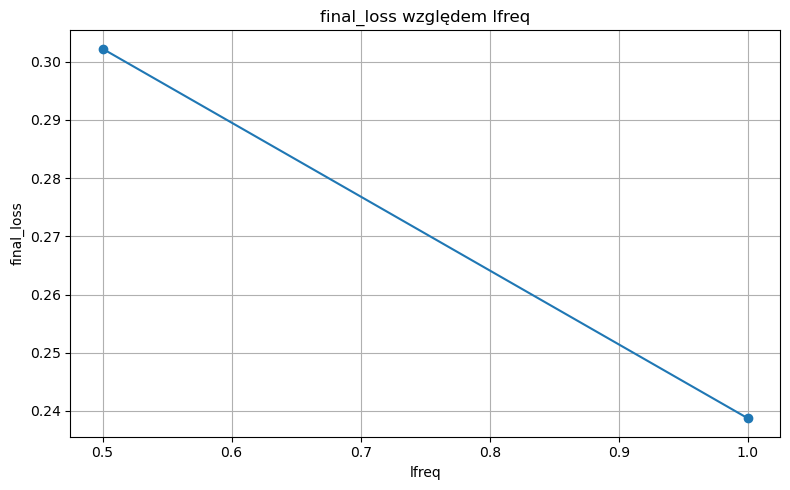

In [4]:
plot_mean_line(df, 'lfreq', 'final_loss')

Zależy nam na minimalizacji funkcji straty - `final_loss`, jak widać zwiększenie `lfreq` zauważalnie zmniejszyło wartość funkcji, co daje nam wskazówkę by próbować kolejnych większych wartości dla `lfreq`

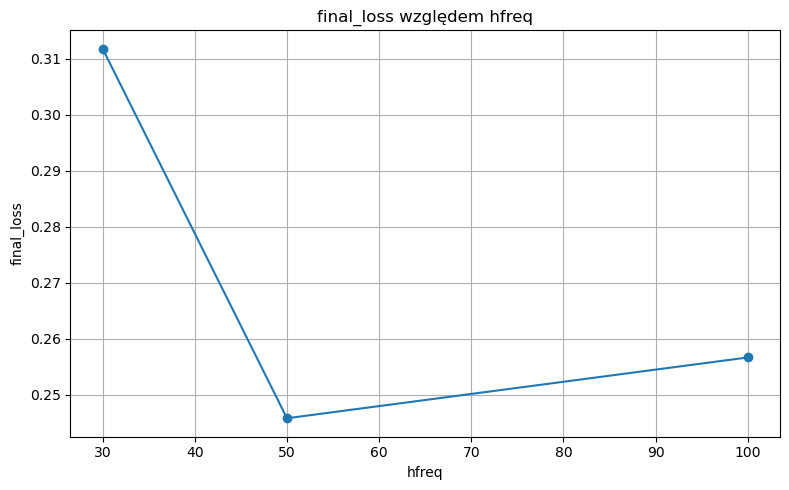

In [5]:
plot_mean_line(df, 'hfreq', 'final_loss')

W przypadku `hfreq` nie jest widoczna jednoznaczna korelacja, natomiast najlepsze rezultaty były uzyskane dla wartości *50.0*, więc warto będzie poszukiwać dalej w okolicach tej wartości

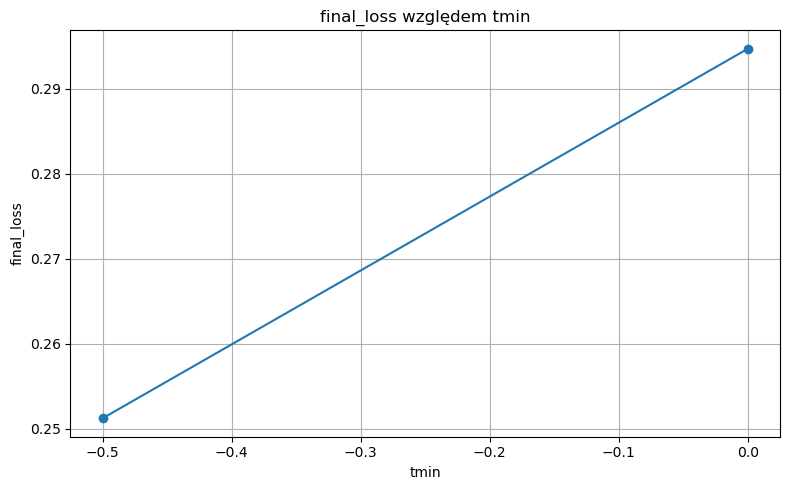

In [6]:
plot_mean_line(df, 'tmin', 'final_loss')

`tmin` zachowuje się przeciwnie do `lfreq` - pozytywna korelacja - więc chcąc minimalizować funkcję będziemy sprawdzać mniejsze wartości `tmin`

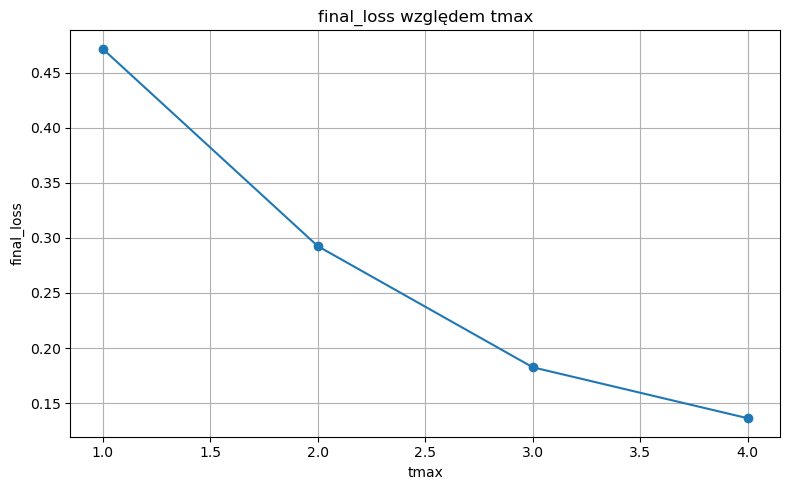

In [7]:
plot_mean_line(df, 'tmax', 'final_loss')

Korelacja dla `tmax` jest negatywna lecz nie wprost liniowa, widzimy że bliżej 4.0 następuje delikatne wypłaszczenie co może sugerować, że jesteśmy blisko optymalnej wartości

# Porównanie TripletLoss dla różnych notch_filter

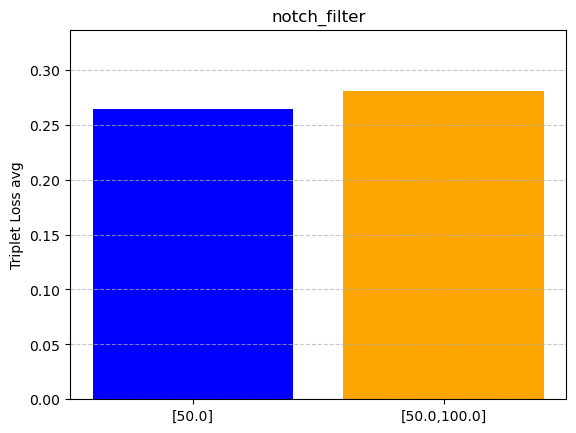

In [8]:
notch_50_avg = df.query('notch_filter == [[50.0]]')['final_loss'].mean()
notch_50_100_avg = df.query('notch_filter == [[50.0, 100.0]]')['final_loss'].mean()


labels = ['[50.0]', '[50.0,100.0]']
values = [notch_50_avg, notch_50_100_avg]

plt.bar(labels, values, color=['blue', 'orange'])
plt.ylabel('Triplet Loss avg')
plt.title('notch_filter')
plt.ylim(0, max(values) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

Jak widać delikatnie lepiej radził sobie `notch_filter` = *[50.0]* - od tego momentu pozostawimy ten parametr stały na tej właśnie wartości

# Korelacja hyperparametrów 
Zerknijmy na pierwszy wiersz/kolumne, otrzymamy wówczas wnioski podobne do tych na podstawie wykresów wyżej:
- `tmax`: **wysoka negatywna korelacja** -> warto przetestować jeszcze wyższe wartości tmax (dotychczas było to 4 max)
- `tmin`: **lekka pozytywna korelacja** -> w połączeniu z punktem wyżej, warto dać większe okno czasowe tj. mniejszy tmin, większy tmax
- `lfreq` i `hfreq`: **lekka negatywna korelacja** -> warto przetestować grid search z jeszcze większymi wartościami na tych hyperparametrach

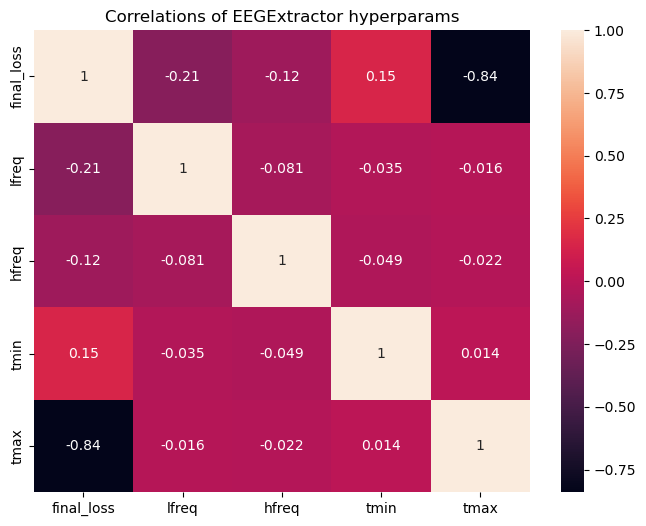

In [9]:
df_params_only = df.drop(['embeddings','labels', 'embedding_dim', 'margin', 'epochs', 'seed'], axis = 1)
df_params_only.drop('notch_filter', axis = 1, inplace=True)
cm = df_params_only.corr()
plt.figure(figsize = (8,6))
plt.title('Correlations of EEGExtractor hyperparams')
sns.heatmap(cm, annot = True)
plt.show()

# Wizualizacja najlepszej konfiguracji hyperparametrow
Po 1 grid searchu zwizualizujmy najlepszą konfigurację

In [10]:
best_emb = df.query('final_loss < 0.091')['embeddings']
best_labels = df.query('final_loss < 0.091')['labels']
best_labels = torch.tensor(best_labels.tolist()).squeeze()
best_emb = torch.tensor(best_emb.tolist()).squeeze()

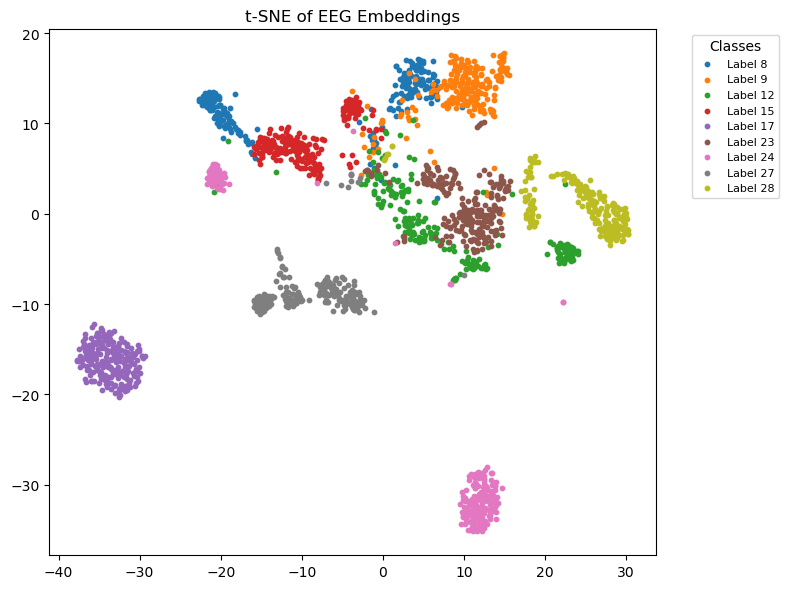

In [11]:
plot_tsne(best_emb, best_labels, perplexity = 100, learning_rate = 100)

# Grid search v2 
Po pierwszym grid searchu nasunęły się pewne wnioski, więc postanowiłem przetestować i zwiększyć/zmniniejszyć hyperparametry extractora
Skupiłem się na:
- `lfreq` [2.0, 4.0] - (wartosci większe)
- `hfreq` [115.0, 124.0] - (wartosci wieksze)
- `notch_filter` [50.0] - (stała)
- `tmin` [-1.0, -1.5] - (wartosci mniejsze)
- `tmax` [5.0, 6.0] - (wartosci wieksze)

co daje nam łącznie **16 kombinacji**

In [12]:
df_2 = pd.read_json('grid_search_final_form_2.json')

df_params_2 = df_2['params'].apply(pd.Series)
df_2 = df_2.join(df_params_2)
df_2.drop('params', axis=1, inplace = True)

In [13]:
df_2.sort_values(by='final_loss').head(3)

,final_loss,embeddings,labels,lfreq,hfreq,notch_filter,tmin,tmax,embedding_dim,margin,epochs,seed
2,0.027168,"[[0.145090252161026, 0.5672390460968011, 0.202...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",2.0,115.0,[50.0],-1.5,5.0,256,0.5,25,42
7,0.029445,"[[0.504798769950866, -0.8116432428359981, 0.01...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",2.0,124.0,[50.0],-1.5,6.0,256,0.5,25,42
10,0.029926,"[[-0.032783228904008005, -0.8718108534812921, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",4.0,115.0,[50.0],-1.5,5.0,256,0.5,25,42


In [14]:
df_2.sort_values(by='final_loss').tail(3)

,final_loss,embeddings,labels,lfreq,hfreq,notch_filter,tmin,tmax,embedding_dim,margin,epochs,seed
8,0.050930,"[[-0.668930172920227, 0.5145580172538751, 0.78...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",4.0,115.0,[50.0],-1.0,5.0,256,0.5,25,42
12,0.054363,"[[0.573188841342926, -0.295736044645309, 0.064...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",4.0,124.0,[50.0],-1.0,5.0,256,0.5,25,42
13,0.059546,"[[0.45771387219429005, 0.15204162895679402, -0...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",4.0,124.0,[50.0],-1.0,6.0,256,0.5,25,42


# Korelacje hyperparametrów z TripletLoss

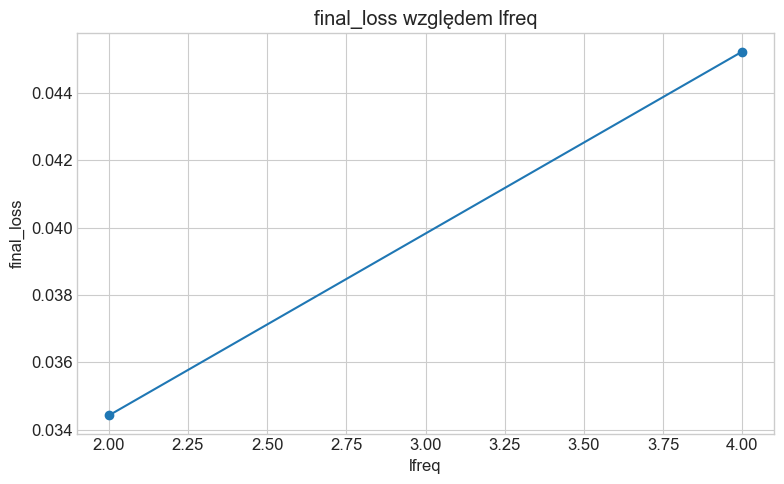

In [80]:
plot_mean_line(df_2, 'lfreq', 'final_loss')

Zwiększenie `lfreq` do *4.0* okazało się być przesadą - warto przetestować wartości w okolicach *2.0*

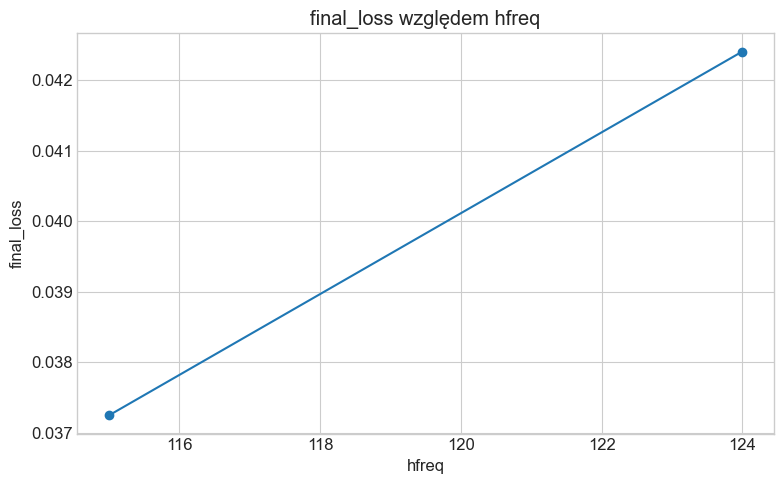

In [81]:
plot_mean_line(df_2, 'hfreq', 'final_loss')

Podobnie dla `hfreq`, przy większych wartościach widzimy **pozytywną korelację** - warto sprawdzić bliżej *115*

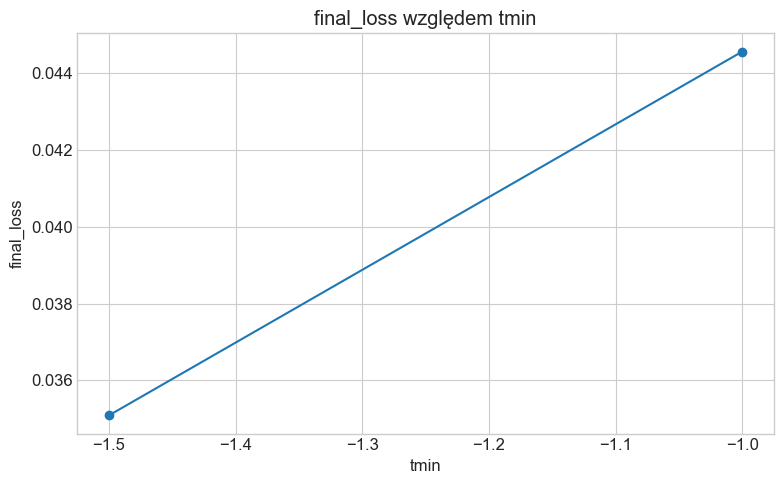

In [82]:
plot_mean_line(df_2, 'tmin', 'final_loss')

Niezmiennie natomiast dla `tmin` dalej **zmniejszenie wartości** daje lepsze rezultaty

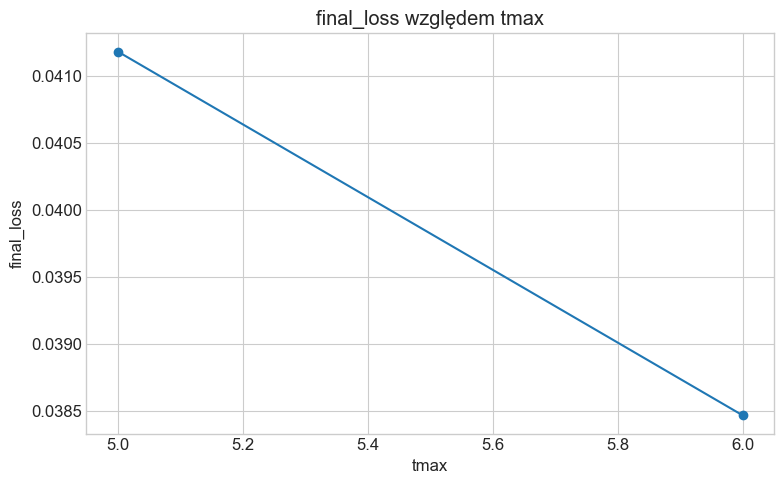

In [83]:
plot_mean_line(df_2, 'tmax', 'final_loss')

Odwrotnie dla `tmax`, co  daje nam wniosek, że im **większe okno czasowe** tym lepiej dla naszego `TripletLoss`

#  Korelacja hyperparametrów 
 ponownie istotny jest tu w praktyce jedynie pierwszy wiersz/kolumna, to ona pokazuje nam jaka zależność jest między TripletLossem a parametrami,
rzeczy do wypróbowania w następnym GridSearchu to:

- wrócić do niższych `lfreq` i `hfreq` (bo mają tu sporą pozytywną korelacje z `triplet_loss`)
- jeszcze bardziej obniżyć `tmin`
- `tmax` nie zwiększac, zostawić i potestować dla wartości zbliżonych do aktualnych

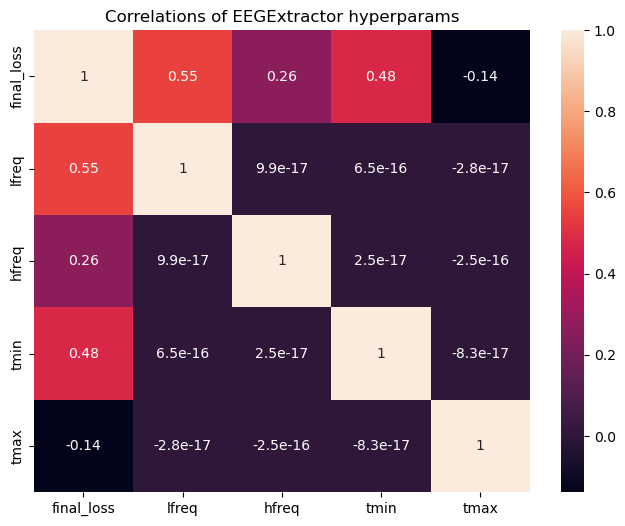

In [19]:
df_params_only_2 = df_2.drop(['embeddings','labels', 'embedding_dim', 'margin', 'epochs', 'seed', 'notch_filter'], axis = 1)
cm_2 = df_params_only_2.corr()
plt.figure(figsize = (8,6))
plt.title('Correlations of EEGExtractor hyperparams')
sns.heatmap(cm_2, annot = True)
plt.show()

# Grid Search v3
W ostatnim grid searchu zostały sprawdzone:

- `lfreq` [1.0, 1.5, 2.0]
- `hfreq` [100.0, 115.0]
- `tmin`  [-2.0, -3.0]
- `tmax`  [4.0, 4.5] 

In [23]:
df_3 = pd.read_json('grid_search_final_form_3.json')

df_params_3 = df_3['params'].apply(pd.Series)
df_3 = df_3.join(df_params_3)
df_3.drop('params', axis=1, inplace = True)

In [24]:
df_3.head(3)

,final_loss,embeddings,labels,lfreq,hfreq,notch_filter,tmin,tmax,embedding_dim,margin,epochs,seed
0,0.059404,"[[-0.062355604022741005, -0.085804611444473, 0...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",1.0,100.0,[50.0],-2.0,4.0,256,0.5,25,42
1,0.055314,"[[0.18253122270107203, 0.091384723782539, -0.0...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",1.0,100.0,[50.0],-2.0,4.5,256,0.5,25,42
2,0.042362,"[[0.287493258714675, 0.205049410462379, -0.351...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",1.0,100.0,[50.0],-3.0,4.0,256,0.5,25,42


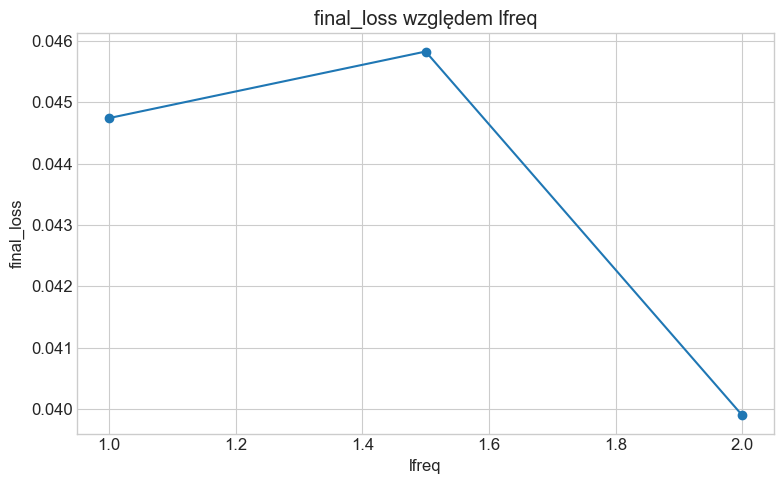

In [84]:
plot_mean_line(df_3, 'lfreq', 'final_loss')

`lfreq` najlepiej wygląda na 2.0

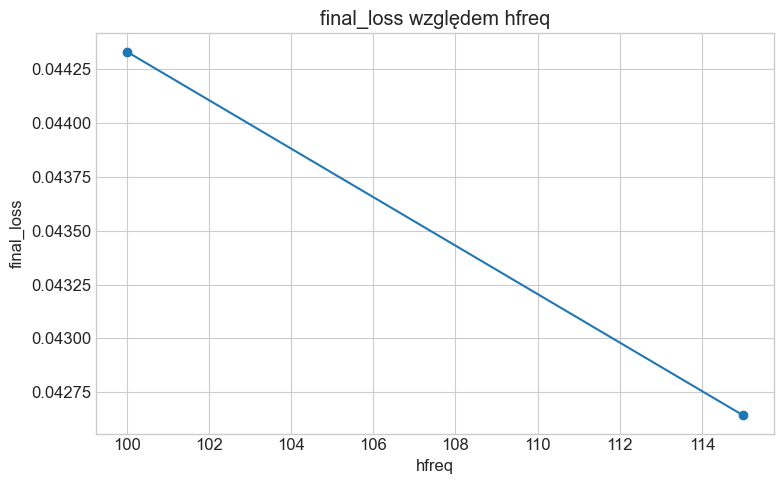

In [85]:
plot_mean_line(df_3, 'hfreq', 'final_loss')

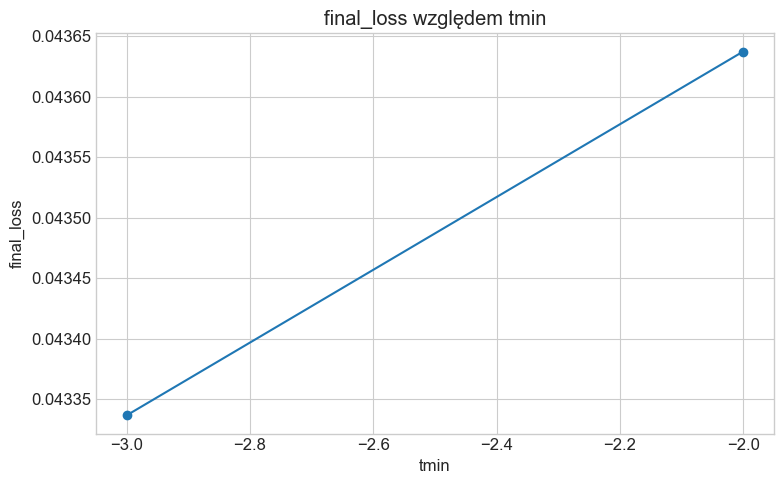

In [87]:
plot_mean_line(df_3, 'tmin', 'final_loss')

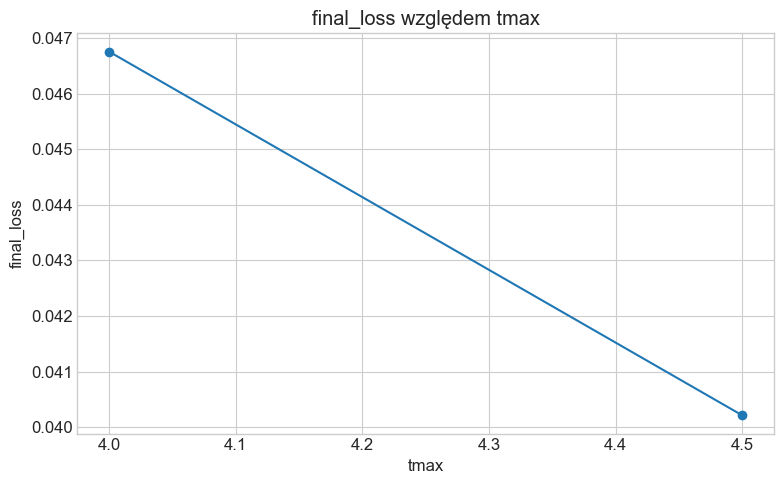

In [90]:
plot_mean_line(df_3, 'tmax', 'final_loss')

In [29]:
df_2.sort_values(by='final_loss').head(1)

,final_loss,embeddings,labels,lfreq,hfreq,notch_filter,tmin,tmax,embedding_dim,margin,epochs,seed
2,0.027168,"[[0.145090252161026, 0.5672390460968011, 0.202...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",2.0,115.0,[50.0],-1.5,5.0,256,0.5,25,42


In [30]:
df_3.sort_values(by='final_loss').head(1)

,final_loss,embeddings,labels,lfreq,hfreq,notch_filter,tmin,tmax,embedding_dim,margin,epochs,seed
21,0.02445,"[[0.61068707704544, 0.36912292242050104, -0.67...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",2.0,115.0,[50.0],-2.0,4.5,256,0.5,25,42


# Złączenie wyników z 3 gridsearchow

Po złączeniu wszystkich 3 badań wnioski są bardziej widoczne

In [39]:
df_combined = pd.concat([df,df_2,df_3], ignore_index = True)

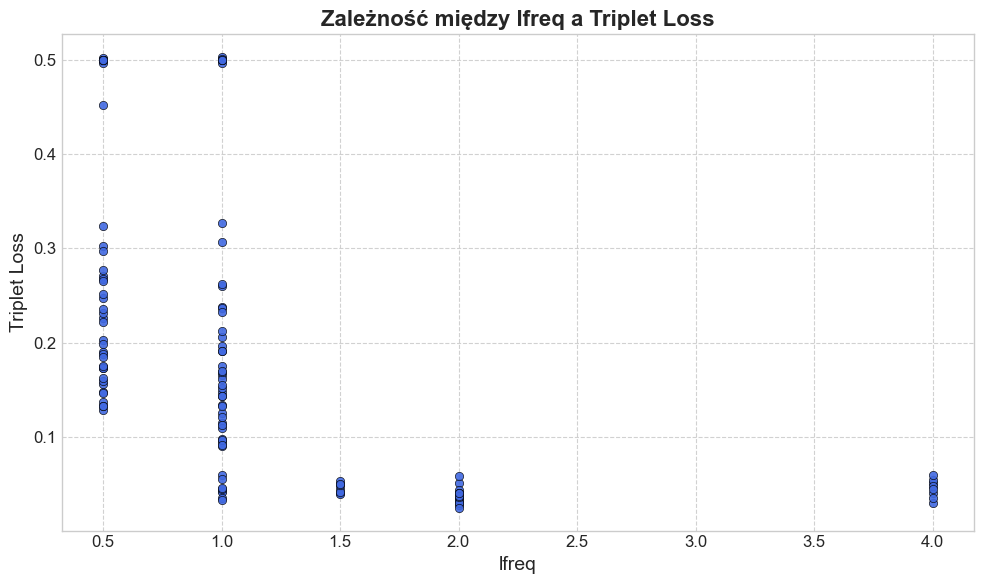

In [55]:
plot_triplet_loss(df_combined, 'lfreq')

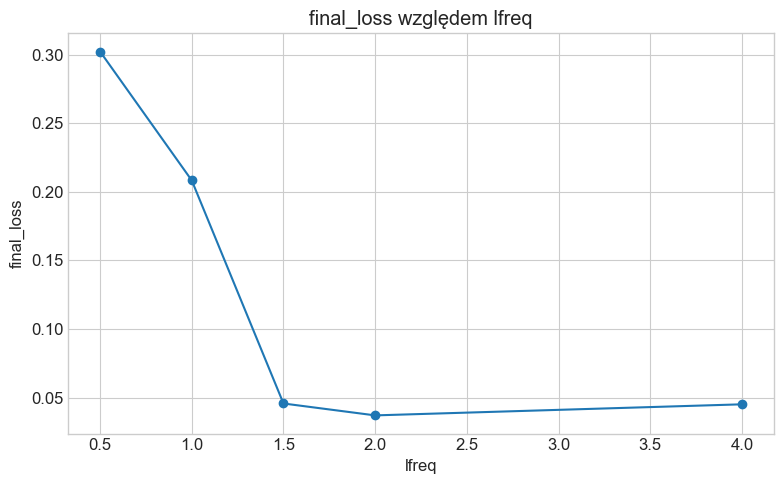

In [91]:
plot_mean_line(df_combined, 'lfreq', 'final_loss')

`lfreq` najlepiej sobie radzi w okolicach 2.0, wartości 1.0 i mniejsze **źle wpływają** na `final_loss`

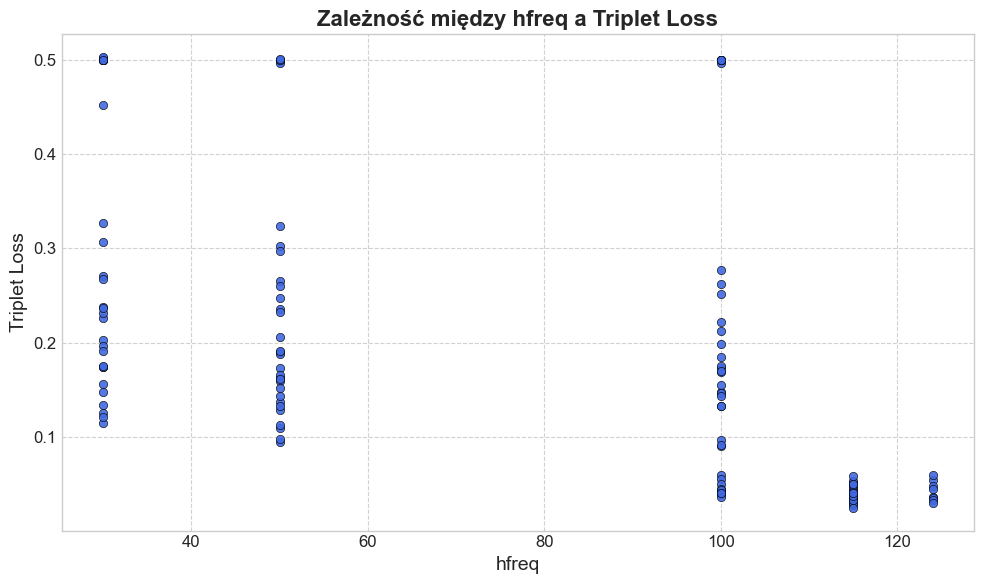

In [56]:
plot_triplet_loss(df_combined, 'hfreq')

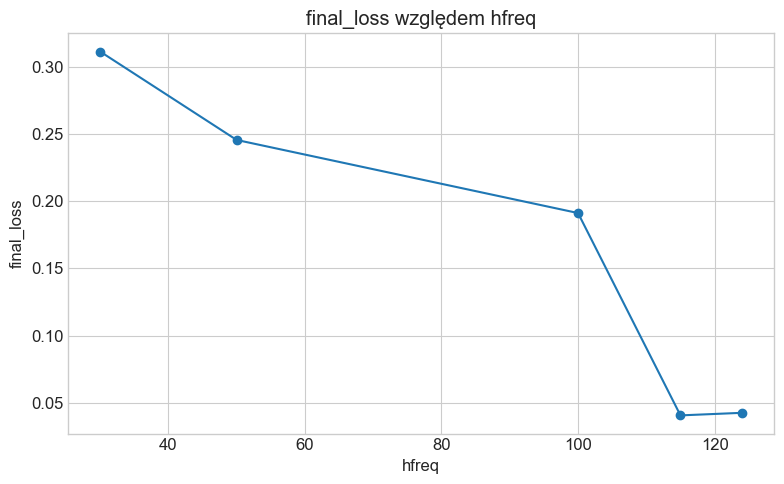

In [92]:
plot_mean_line(df_combined, 'hfreq', 'final_loss')

najlepszymi wartościami dla `hfreq` są 115.0 +

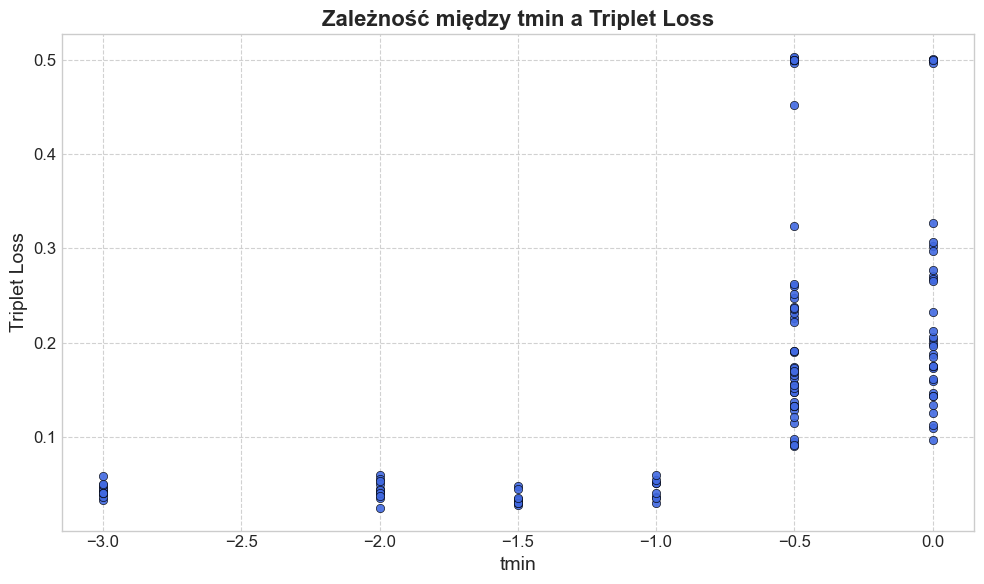

In [57]:
plot_triplet_loss(df_combined, 'tmin')

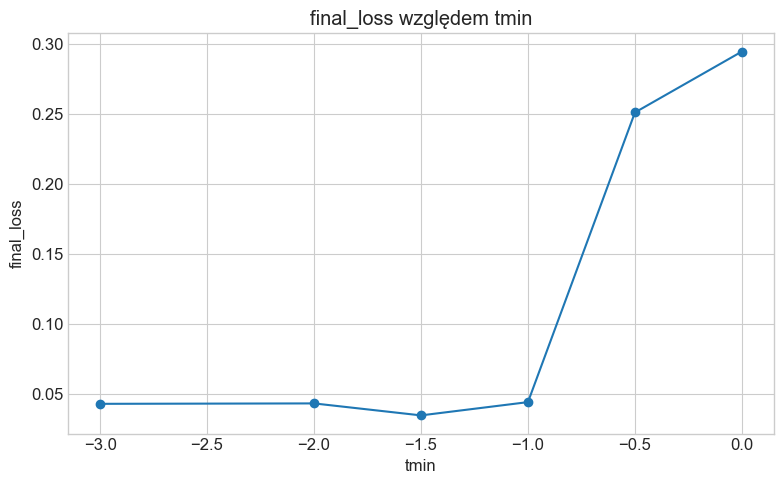

In [93]:
plot_mean_line(df_combined, 'tmin', 'final_loss')

`tmin` znacznie lepiej minimalizuje funkcje przy wartościach od -1.0 w dół (tu najlepiej dla -1.5)

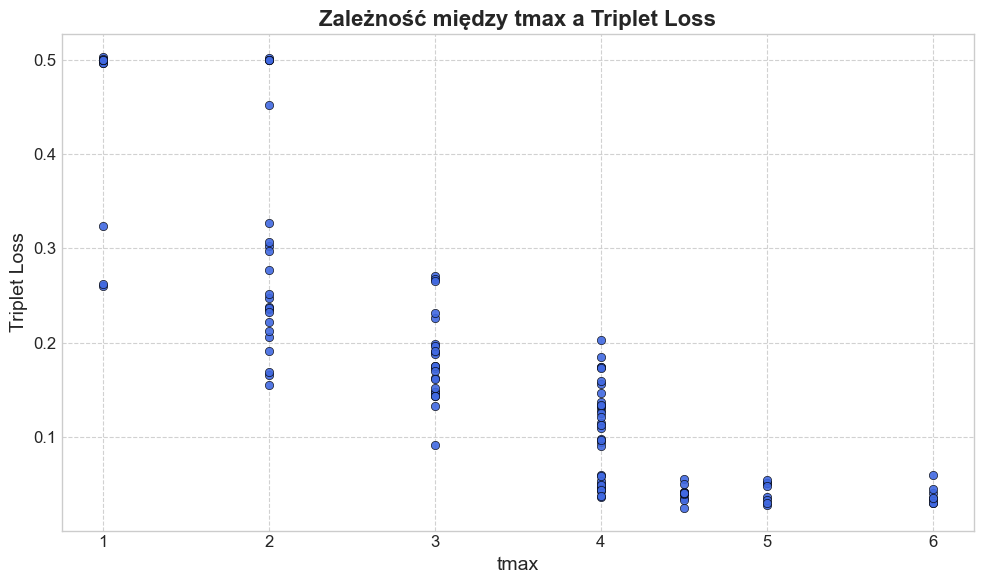

In [58]:
plot_triplet_loss(df_combined, 'tmax')

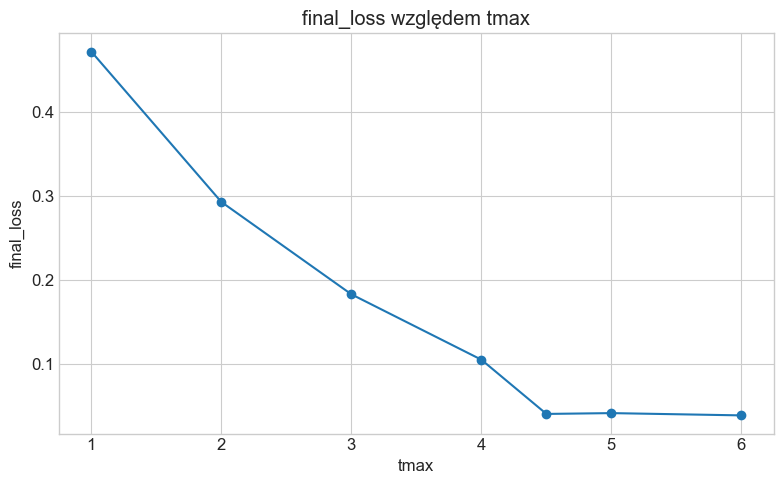

In [94]:
plot_mean_line(df_combined, 'tmax', 'final_loss')

`tmax` najlepiej wygląda przy 4.5 w górę (co w połączeniu z niskim `tmin` daje nam potwierdzenie wniosku z dużym oknem czasu)

In [62]:
df_combined.sort_values(by = 'final_loss').head(3)

,final_loss,embeddings,labels,lfreq,hfreq,notch_filter,tmin,tmax,embedding_dim,margin,epochs,seed
128,0.024450,"[[0.61068707704544, 0.36912292242050104, -0.67...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",2.0,115.0,[50.0],-2.0,4.5,256,0.5,25,42
93,0.027168,"[[0.145090252161026, 0.5672390460968011, 0.202...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",2.0,115.0,[50.0],-1.5,5.0,256,0.5,25,42
98,0.029445,"[[0.504798769950866, -0.8116432428359981, 0.01...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",2.0,124.0,[50.0],-1.5,6.0,256,0.5,25,42


In [64]:
df_combined.sort_values(by = 'final_loss').tail(3)

,final_loss,embeddings,labels,lfreq,hfreq,notch_filter,tmin,tmax,embedding_dim,margin,epochs,seed
76,0.500749,"[[0.25880882143974304, -0.322870105504989, -0....","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",1.0,50.0,"[50.0, 100.0]",0.0,1.0,256,0.5,25,42
1,0.502187,"[[0.27242556214332503, -0.076106570661067, -0....","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",0.5,30.0,[50.0],-0.5,2.0,256,0.5,25,42
56,0.503068,"[[-0.008160537108778001, 0.049680788069963004,...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",1.0,30.0,"[50.0, 100.0]",-0.5,1.0,256,0.5,25,42


# Finalna korelacje hyperparametrów

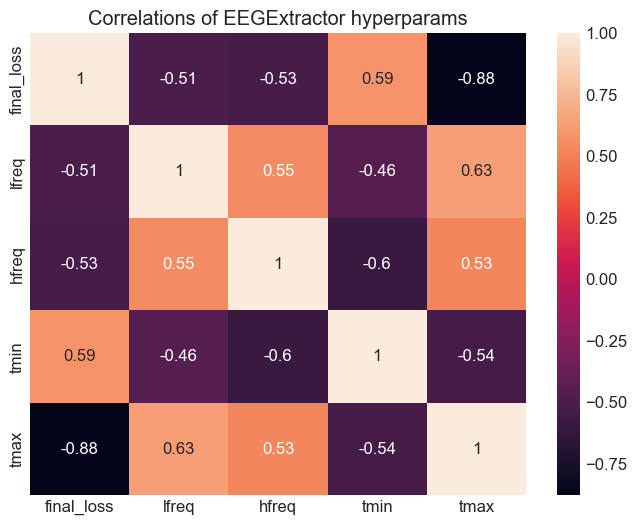

In [63]:
df_params_only_c = df_combined.drop(['embeddings','labels', 'embedding_dim', 'margin', 'epochs', 'seed', 'notch_filter'], axis = 1)
cm_c = df_params_only_c.corr()
plt.figure(figsize = (8,6))
plt.title('Correlations of EEGExtractor hyperparams')
sns.heatmap(cm_c, annot = True)
plt.show()

In [65]:
best_embc = df_combined.sort_values(by='final_loss').head(1)['embeddings']
best_labelsc = df_combined.sort_values(by='final_loss').head(1)['labels']
best_labelsc = torch.tensor(best_labelsc.tolist()).squeeze()
best_embc = torch.tensor(best_embc.tolist()).squeeze()

In [66]:
worst_embc = df_combined.sort_values(by='final_loss').tail(1)['embeddings']
worst_labelsc = df_combined.sort_values(by='final_loss').tail(1)['labels']
worst_labelsc = torch.tensor(worst_labelsc.tolist()).squeeze()
worst_embc = torch.tensor(worst_embc.tolist()).squeeze()

# Porównanie najlepszej i najgorszej kombinacji hyperparametrów (wizulaizacja z t-SNE)

Jak widać klastry w najlepszej wersji wyglądają już całkiem nieźle podczas gdy w najorszych rezultatach, ciężko zauważyć chociaż jeden

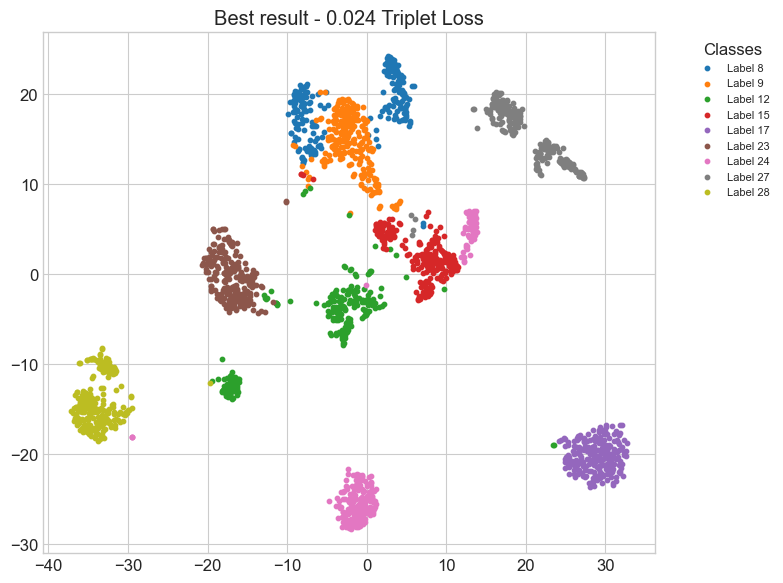

In [68]:
plot_tsne(best_embc, best_labelsc, perplexity = 100, learning_rate = 100, title = "Best result - 0.024 Triplet Loss")

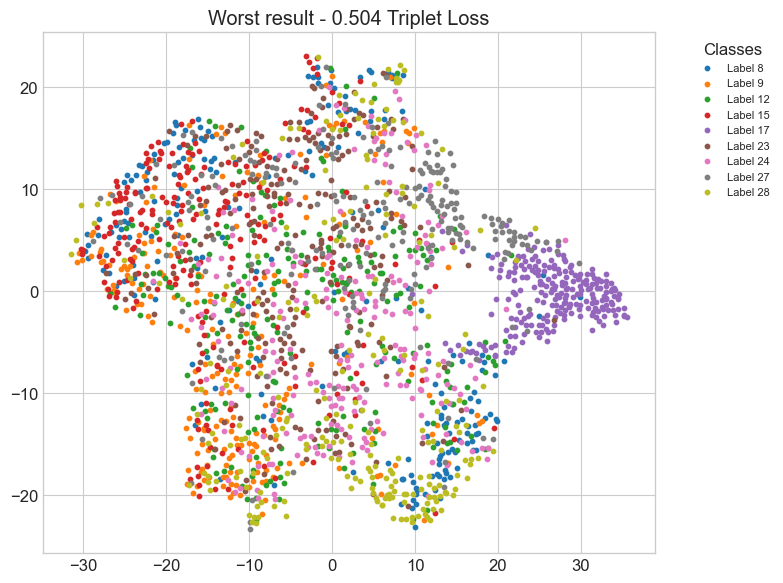

In [69]:
plot_tsne(worst_embc, worst_labelsc, perplexity = 100, learning_rate = 100, title = "Worst result - 0.504 Triplet Loss")

# Podsumowanie całości:
Najlepszymi parametrami okazały się być:
- `lfreq` = **2.0**
- `hfreq` = **115.0**
- `notch_filter` = **[50.0]**
- `tmin` = **-2.0**
- `tmax` = **4.5**

Ponadto badanie wykazało że dobór parametrów w extractorze ma istotny wpływ na późniejszą jakość wyników (patrz TripletLoss, oraz powyższy wykres t-SNE najlepszy vs najgorszy) 

wykresy zależności funkcji straty (TripletLoss) od wartości danego parametru pokazują trend, który daje pole do dalszego testowania

W przyszłości operując już na tych parametrach, warto sprawdzić również optymalne dimensionality dla embeddingu oraz liczbe epoch w treningu, a także poeksperymentować z różnymi wariacjami modelu konwolucyjnego lub innymi architekturami